In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

from vulkan_public.beam.local.runner import PolicyRunner
from vulkan_public.core.policy import Policy
from vulkan_public.schemas import DataSourceSpec
from vulkan_public.spec.dependency import INPUT_NODE

## Preparations

We'll create a Parquet file with our input data, and a second file to act as a "Data Source".

Data Sources bring external data into your workflow. 
This can be done by consulting a bureau, or by having some test data, like in our case here.

In [3]:
df = pd.read_csv("../data/simple_bkt_lg.csv")
df["month"] = df["month"].astype(str)
df["tax_id"] = df["tax_id"].astype(str)

df.to_parquet("input.parquet")

lookup_df = df[["tax_id", "score"]]
lookup_df.to_parquet("file_data_source.parquet")

## Define the Policy

This is all the code used to define the policy. \
In fact, in `docs/examples/policies/local/test_policy/policy.py` 
we use the exact same code to create our "packaged" version, 
which we'll use later for remote execution.

There are a few key parts here:
- `DataInputNode`: These nodes are used to bring data into your decision flows. Here, we'll use a local file, but this can later be replaced with an API or database without having to change the flow
- `branch_condition` and `BranchNode`: "Branches" are how we make decisions in our policies. At a branch, you can have any number of possible outputs. In our case here, we write a function that returns "approved" if the score is greater than a cutoff.
- `TerminateNode`: Terminate nodes are how we represent the final step in a policy, or the final decision. The `return_status` value is the final decision made. Here, we either approve or deny someone. We'll later see how this can be used to pass information to other systems.

In [4]:
from vulkan_public.spec.dependency import INPUT_NODE, Dependency
from vulkan_public.spec.nodes import BranchNode, DataInputNode, TerminateNode
from vulkan_public.spec.policy import PolicyDefinition

data_source = DataInputNode(
    name="data_source",
    description="Get external data from a provider",
    data_source="data-source:api:v0.0.1",
    dependencies={"data": Dependency(INPUT_NODE)},
)


# Branching node
def branch_condition(context, bureau, **kwargs):
    context.log.info(bureau)
    if bureau["score"] > context.env.get("MINIMUM_SCORE"):
        return "approved"
    return "denied"


branch = BranchNode(
    func=branch_condition,
    name="branch",
    description="Make a decision based on the data source",
    dependencies={
        "bureau": Dependency(data_source.name),
    },
    choices=["approved", "denied"],
)

approved = TerminateNode(
    name="approved",
    description="Approve customer based on the score",
    return_status="APPROVED",
    dependencies={"condition": Dependency("branch", "approved")},
)

denied = TerminateNode(
    name="denied",
    description="Deny customers that are below minimum",
    return_status="DENIED",
    dependencies={"condition": Dependency("branch", "denied")},
)

demo_policy = PolicyDefinition(
    nodes=[
        data_source,
        branch,
        approved,
        denied,
    ],
    config_variables=["MINIMUM_SCORE"],
    input_schema={"tax_id": str},
)

### Visualizing the flow of information

We can visualize our policy locally, at all times. \
This can show us how the clients are being treated and where we're making each decision.

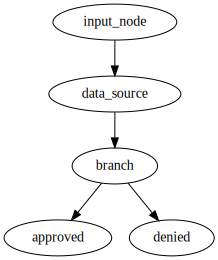

In [7]:
demo_policy.show()

In [8]:
policy = Policy.from_definition(demo_policy)

## Run the Policy Locally 

The entire policy can be visualized and the run locally.

To do that, we'll just have to do two things:
1. Set a value for our score "cutoff": the minimum score to be Approved;
2. Create a schema, telling Vulkan where to get data for the data sources;

In [9]:
config_variables = {"MINIMUM_SCORE": 500}

test_file_schema = {
    "name": "data-source:api:v0.0.1",
    "keys": ["tax_id"],
    "source": {
        "path": "file_data_source.parquet",
    },
    "caching": {
        "enabled": False,
    },
}

data_sources = [
    DataSourceSpec.model_validate(test_file_schema),
]

In [10]:
runner = PolicyRunner(policy, staging_path="./output/")

### Running

Now we're ready to run our policy.

Let's start with a single example:

In [12]:
lookup_df.head()

,tax_id,score
0,0,81
1,1,836
2,2,48
3,3,952
4,4,650


In [14]:
%%time
result = runner.run(
    input_data={"tax_id": "3"},
    data_sources=data_sources,
    config_variables=config_variables,
)

print("Here are our results:\n")
result.data

Here are our results:

CPU times: user 478 ms, sys: 60.2 ms, total: 538 ms
Wall time: 586 ms


{'input_node': [{'tax_id': '3'}], 'result': [{'status': 'APPROVED'}]}

### Running for a bunch of data

We can run for 1 example, or for a bunch, just as easily. \
To run for a batch of data, we just need to pass the input data with a file. \
Let's pass in the input file we created at the beginning.

In [15]:
%%time
batch_results = runner.run_batch(
    input_data_path="input.parquet",
    data_sources=data_sources,
    config_variables=config_variables,
)

CPU times: user 1.94 s, sys: 247 ms, total: 2.18 s
Wall time: 2.3 s


In [16]:
batch_results.data

,backfill_id,key,status,input_node
0,1743085988965655,f0369ba55a60b5bc5bc8666a964c395c,DENIED,{'tax_id': '0'}
1,1743085988965655,60a146574a1ec5f09a27e1f15ae95ded,APPROVED,{'tax_id': '1'}
2,1743085988965655,761f36e599f6ca3cfb859271468973f2,DENIED,{'tax_id': '2'}
3,1743085988965655,3254c1565be80b4fe68c057671204ff6,APPROVED,{'tax_id': '3'}
4,1743085988965655,0e16afcc463ccb97987fd290aa35dc9d,APPROVED,{'tax_id': '4'}
...,...,...,...,...
995,1743085988965655,53861153a4b25a166752c788cf1d6e36,DENIED,{'tax_id': '995'}
996,1743085988965655,7fd9223d882ffd7bdcd47b6a58992371,APPROVED,{'tax_id': '996'}
997,1743085988965655,b41eaa06a9f79346369d7ebe486df932,APPROVED,{'tax_id': '997'}
998,1743085988965655,f4e11cf9a984c8554f09aa7720c6a7b8,DENIED,{'tax_id': '998'}
